### Import des librairies

In [197]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree

### Définition de fonctions utilitaires

In [198]:
def class_from_indice(indice):
    """A partir du tranquili'score calculé entre 0 et 1 sur les jours passés, le place parmi 5 niveaux de score utilisé pour la classification"""
    if np.isnan(indice):
        return 0
    elif 0<=indice<0.2:
        return 1
    elif 0.2<=indice<0.4:
        return 2
    elif 0.4<=indice<0.6:
        return 3
    elif 0.6<=indice<0.8:
        return 4
    elif 0.8<=indice<=1:
        return 5
    else:
        raise ValueError("l'indice n'est pas entre 0 et 1 : " + str(indice))

### Pré-processing de la base de donnée

In [199]:
# On importe la base de données
df = pd.read_csv("../Données/Données pré-traitées/Base_de_donnees_finale.csv")

df = df[['Jour-heure','Gare_A','Gare_B','Indice_troncon_AB','Indice_gare_A','Indice_gare_B']]

df["Jour-heure"] = pd.to_datetime(df["Jour-heure"])

df["numero_jour"] = df["Jour-heure"].dt.day
df["mois"] = df["Jour-heure"].dt.month
df["annee"] = df["Jour-heure"].dt.year
df["day_of_the_week"] = df["Jour-heure"].dt.weekday
df["minute"] = df["Jour-heure"].dt.minute
df["heure"] = df["Jour-heure"].dt.hour
df = df.drop(["Jour-heure"], axis=1)

#On encode en one-hot les données des gares pour les rendre lisible par le classifier qu'on va utilisre

df_encoded = pd.get_dummies(df, columns=['Gare_A','Gare_B'], dtype=int)

df_encoded["Indice_troncon_AB"] = df_encoded["Indice_troncon_AB"].apply(class_from_indice)
df_encoded["Indice_gare_A"] = df_encoded["Indice_gare_A"].apply(class_from_indice)
df_encoded["Indice_gare_B"] = df_encoded["Indice_gare_B"].apply(class_from_indice)

# Tree classifier

In [209]:
df_encoded

,Indice_troncon_AB,Indice_gare_A,Indice_gare_B,numero_jour,mois,annee,day_of_the_week,minute,heure,Gare_A_CEG,...,Gare_B_ERT,Gare_B_FPB,Gare_B_GDS,Gare_B_LBJ,Gare_B_MBP,Gare_B_PRY,Gare_B_PSE,Gare_B_SDE,Gare_B_SOA,Gare_B_SOL
0,0,0,0,1,11,2023,2,0,6,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,11,2023,2,5,6,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,11,2023,2,10,6,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,11,2023,2,15,6,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,11,2023,2,20,6,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89289,0,0,0,15,11,2023,2,35,22,0,...,0,0,1,0,0,0,0,0,0,0
89290,0,0,0,15,11,2023,2,40,22,0,...,0,0,1,0,0,0,0,0,0,0
89291,0,0,0,15,11,2023,2,45,22,0,...,0,0,1,0,0,0,0,0,0,0
89292,0,0,0,15,11,2023,2,50,22,0,...,0,0,1,0,0,0,0,0,0,0


In [219]:
# Définir les paramètres à optimiser
param_grid = {
    # 'n_estimators': [50, 100, 150],
    # 'max_depth': [10, 20, 30, None],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'bootstrap': [True, False]
}

out = df_encoded[df_encoded.numero_jour == 15].drop(["Indice_troncon_AB","Indice_gare_A","Indice_gare_B"], axis=1).copy()

for indice in ["Indice_troncon_AB","Indice_gare_B","Indice_gare_A"]:
    df_encoded_train = df_encoded[df_encoded.numero_jour < 15]
    df_encoded_test =  df_encoded[df_encoded.numero_jour == 15]
    
    X_train = df_encoded_train.drop(["Indice_troncon_AB","Indice_gare_A","Indice_gare_B"], axis=1)
    X_test = df_encoded_test.drop(["Indice_troncon_AB","Indice_gare_A","Indice_gare_B"], axis=1)

    Y_train = df_encoded_train[[indice]]
    Y_test = df_encoded_test[[indice]]

    clf = RandomForestClassifier(max_depth=30)

    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

    start_time = time.time()
    
    # entraine le classifier avec gridsearch pour optimiser les paramètres
    grid_search.fit(X_train, Y_train.values.ravel())
    
    # Meilleurs paramètres trouvés par GridSearchCV
    best_params = grid_search.best_params_
    print("Meilleurs paramètres trouvés :", best_params)

    # Utiliser le meilleur modèle pour prédire
    best_clf = grid_search.best_estimator_

    end_time = time.time()

    training_time = end_time - start_time
    
    print(f"Temps d'entraînement : {training_time:.2f} secondes")

    start_time = time.time()

    # predict using classifier
    Y_pred = best_clf.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time

    print(f"Temps de prédiction : {prediction_time:.2f} secondes")

    # claculate accuracy
    accuracy = accuracy_score(Y_test, Y_pred)
    print('Accuracy pour la prédiciton de ' + indice + f' : {accuracy}')
    
    print("Paramètres du modèle :")
    print(clf.get_params())
    
    out["prediction_"+indice] = Y_pred

Fitting 3 folds for each of 1 candidates, totalling 3 fits


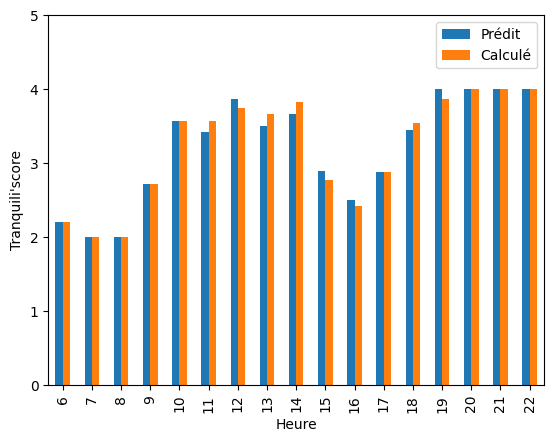

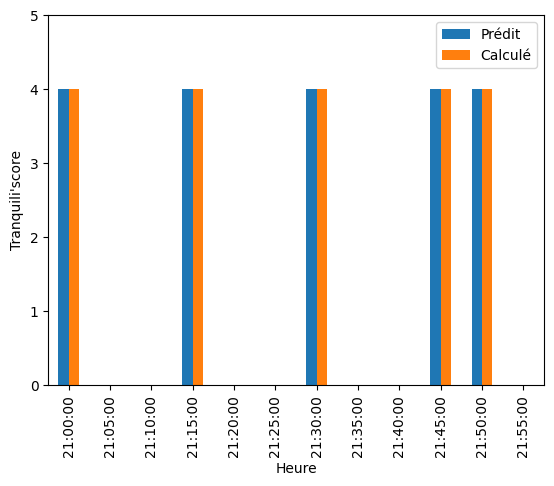

In [ ]:
resultat = X_test.copy()
resultat["prediction_indice_gare_A"] = Y_pred
resultat["test_indice_gare_A"] = Y_test
resultat['heure_minute'] = resultat.apply(lambda row: datetime.time(datetime.strptime(f"{row['heure']}:{row['minute']}", "%H:%M")), axis=1)
resultat = resultat.sort_values('heure_minute')
resultat = resultat[(resultat.Gare_A_ERT == 1) & (resultat.heure > 5)]
resultat = resultat.drop_duplicates()
resultat_plot = resultat[["prediction_indice_gare_A","test_indice_gare_A","heure"]][~(resultat["prediction_indice_gare_A"] == 0)].groupby("heure").mean()
ax = resultat_plot.plot(kind="bar", ylim=(0,5))
ax.set_xlabel("Heure")
ax.set_ylabel("Tranquili'score")
ax.legend(["Prédit","Calculé"], loc="upper right")

resultat_plot = resultat[resultat.heure == 21][["heure_minute","prediction_indice_gare_A","test_indice_gare_A"]]
ax2 = resultat_plot.plot(kind="bar", x="heure_minute",y=["prediction_indice_gare_A","test_indice_gare_A"], ylim=(0,5))
ax2.set_xlabel("Heure")
# ax2.set_xticklabels(resultat_plot.heure_minute, rotation=35, ha='right')
ax2.set_ylabel("Tranquili'score")
ax2.legend(["Prédit","Calculé"], loc="upper right")


In [ ]:
# visualisation des premiers étages de l'arbre

# estimator = clf.estimators_[0]

# fig = plt.figure(figsize=(50,10))
# _ = tree.plot_tree(estimator,
#                    filled=True, 
#                 max_depth=5)